# NHANES I Survival Model

This is a cox proportional hazards model on data from <a href="https://wwwn.cdc.gov/nchs/nhanes/nhanes1">NHANES I</a> with followup mortality data from the <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs">NHANES I Epidemiologic Followup Study</a>. It is designed to illustrate how SHAP values enable the interpretion of XGBoost models with a clarity traditionally only provided by linear models. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. Keep in mind the data has not yet been checked by us for calibrations to current lab tests and so you should not consider the results as actionable medical insights, but rather a proof of concept. 

Note that support for Cox loss and SHAP interaction effects were only recently merged, so you will need the latest master version of XGBoost to run this notebook.

In [146]:
import shap
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

## Prepare Data

This uses a pre-processed subset of NHANES I data available in the SHAP datasets module.

In [195]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

## Vanilla XGBoost model

In [155]:
fit_params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5,
    "n_estimators": 100,
    "random_state": 34,
    "seed": 34
}
orig_model = XGBRegressor(**fit_params)
orig_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=int(fit_params["n_estimators"]/5))

[0]	validation_0-cox-nloglik:7.12869
[20]	validation_0-cox-nloglik:6.55299
[40]	validation_0-cox-nloglik:6.50416
[60]	validation_0-cox-nloglik:6.49395
[80]	validation_0-cox-nloglik:6.49788
[99]	validation_0-cox-nloglik:6.51104


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eta=0.002, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='survival:cox', random_state=34,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=34, silent=None,
       subsample=0.5, verbosity=1)

## XGBoost model with SHAP feature importances

In [169]:
import numpy as np
import shap
from xgboost import XGBRegressor


class ShapXGBRegressor(XGBRegressor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.vanilla_model = XGBRegressor(**kwargs)
        self.feature_importances = None

    @property
    def feature_importances_(self):
        return self.feature_importances
    
    @property
    def vanilla_feature_importances(self):
        return super().feature_importances_

    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        self.vanilla_model.__dict__ = self.__dict__
        self._calculate_feature_importances(X)
        return self

    def _calculate_feature_importances(self, X):
        explainer = shap.TreeExplainer(self.vanilla_model)
        shap_values = explainer.shap_values(X)
        feature_importances = np.mean(np.abs(shap_values), axis=0)
        self.feature_importances = feature_importances

    def get_params(self, deep=False):
        return self.vanilla_model.get_params(deep)

In [186]:
my_model = ShapXGBRegressor(**fit_params)
my_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=int(fit_params["n_estimators"]/5))

[0]	validation_0-cox-nloglik:7.12869
[20]	validation_0-cox-nloglik:6.55299
[40]	validation_0-cox-nloglik:6.50416
[60]	validation_0-cox-nloglik:6.49395
[80]	validation_0-cox-nloglik:6.49788
[99]	validation_0-cox-nloglik:6.51104


ShapXGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, eta=0.002, gamma=0,
         importance_type='gain', learning_rate=0.1, max_delta_step=0,
         max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
         n_jobs=1, nthread=None, objective='survival:cox', random_state=34,
         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=34,
         silent=None, subsample=0.5, verbosity=1)

## Compare feature importances

In [187]:
(my_model.vanilla_feature_importances == orig_model.feature_importances_).all()

True

In [188]:
orig_model.feature_importances_

array([0.02837274, 0.3421058 , 0.04055583, 0.03419708, 0.01927379,
       0.02602945, 0.04228061, 0.041077  , 0.03282125, 0.02964063,
       0.03748016, 0.02886848, 0.07809756, 0.04533925, 0.02949669,
       0.0309557 , 0.04009185, 0.03375924, 0.03955674], dtype=float32)

In [189]:
my_model.feature_importances_

array([0.02230697, 1.2602944 , 0.09946342, 0.11448295, 0.00693359,
       0.0219535 , 0.0549446 , 0.04781595, 0.05127395, 0.03270031,
       0.05935754, 0.04265623, 0.29262108, 0.11732519, 0.02903319,
       0.03753575, 0.08687518, 0.08802547, 0.04167419], dtype=float32)

## Use models for feature selection

In [215]:
from sklearn.impute import SimpleImputer

def impute(df):
    imputer = SimpleImputer(strategy='median')
    df_imputed = df.copy()
    df_imputed[:] = imputer.fit_transform(df)
    return df_imputed    

def impute_train_test(X_train, X_test):
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)
    
    X_train_imputed = X_train.copy()
    X_train_imputed[:] = imputer.transform(X_train)
    
    X_test_imputed = X_test.copy()
    X_test_imputed[:] = imputer.transform(X_test)
    
    return X_train_imputed, X_test_imputed

X_train_imputed, X_test_imputed = impute_train_test(X_train, X_test)
X_imputed = impute(X)

In [217]:
from sklearn.feature_selection import RFE

estimator = XGBRegressor(**fit_params)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_imputed, y)
print(np.nonzero(selector.support_)[0])
print(selector.support_)
print(selector.ranking_)

estimator = ShapXGBRegressor(**fit_params)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_imputed, y)
print(np.nonzero(selector.support_)[0])
print(selector.support_)
print(selector.ranking_)


[ 1  2  6 12 13]
[False  True  True False False False  True False False False False False
  True  True False False False False False]
[15  1  1  3 13  8  1  2 12 11  6  7  1  1 14 10  4  5  9]
[ 1  3 12 13 16]
[False  True False  True False False False False False False False False
  True  True False False  True False False]
[13  1  6  1 15 12  9  2  8 11  5  3  1  1 14  7  1  4 10]


In [221]:
np.argsort(orig_model.feature_importances_)[::-1]

array([ 1, 12, 13,  6,  7,  2, 16, 18, 10,  3, 17,  8, 15,  9, 14, 11,  0,
        5,  4], dtype=int64)

In [220]:
np.argsort(my_model.feature_importances_)[::-1]

array([ 1, 12,  3, 13, 17,  2, 16, 10,  6,  7, 11,  8,  9, 15,  5, 14,  0,
       18,  4], dtype=int64)

In [218]:
X.columns[np.nonzero(selector.support_)[0]]

Index(['Age', 'Poverty index', 'Sex', 'Systolic BP', 'White blood cells'], dtype='object')

In [140]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = ShapXGBRegressor(**params, random_state=34, seed=34)
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

X = X[:,::-1]
estimator = ShapXGBRegressor(**params, random_state=34, seed=34)
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)


[ True  True  True  True  True False False False False False]
[1 1 1 1 1 6 3 2 5 4]
[False False False False False  True  True  True  True  True]
[2 5 4 3 6 1 1 1 1 1]


## Explain the model's predictions on the entire dataset

In [68]:
shap_values = shap.TreeExplainer(model).shap_values(X)

Exception: Model type not yet supported by TreeExplainer: <class '__main__.ShapXGBRegressor'>

### SHAP Summary Plot

The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. We can see below that the primary risk factor for death according to the model is being old. The next most powerful indicator of death risk is being a man.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

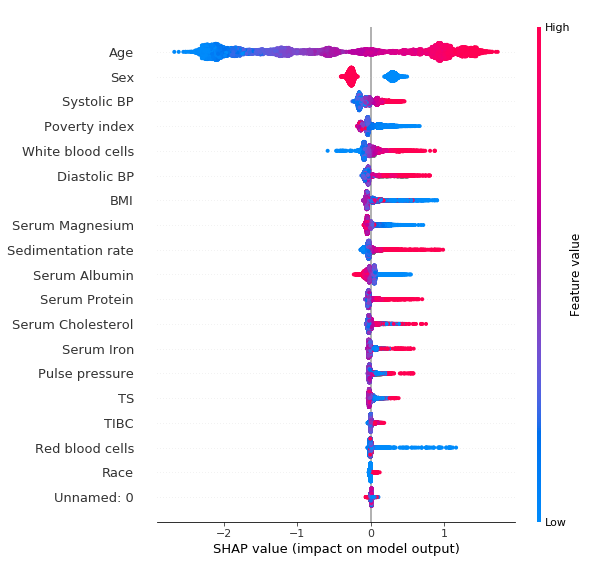

In [7]:
shap.summary_plot(shap_values, X)

### SHAP Dependence Plots

While a SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. Note that the row of a SHAP summary plot results from projecting the points of a SHAP dependence plot onto the y-axis, then recoloring by the feature itself.

Below we give the SHAP dependence plot for each of the NHANES I features, revealing interesting but expected trends. Keep in mind the calibration of some of these values can be different than a modern lab test so be careful drawing conclusions.

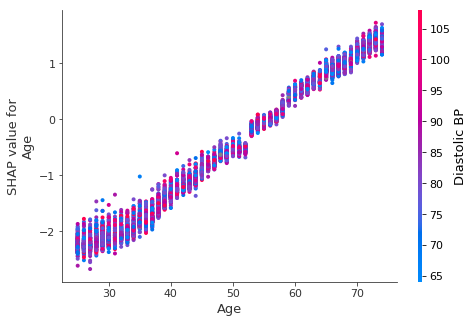

In [8]:
# we pass "Age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that 
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("Age", shap_values, X)

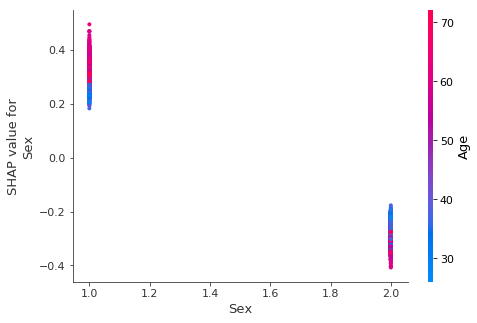

In [10]:
# we pass display_features so we get text display values for sex
shap.dependence_plot("Sex", shap_values, X)

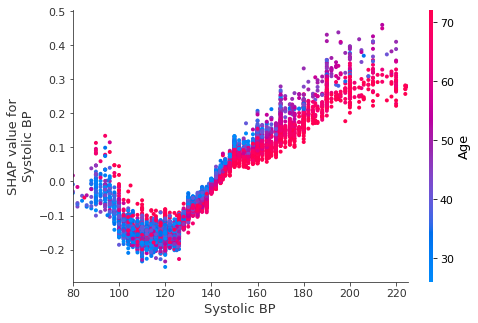

In [11]:
# setting show=False allows us to continue customizing the matplotlib plot before displaying it
shap.dependence_plot("Systolic BP", shap_values, X, show=False)
pl.xlim(80,225)
pl.show()

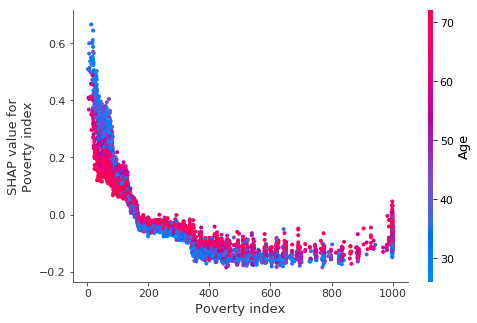

In [12]:
shap.dependence_plot("Poverty index", shap_values, X)

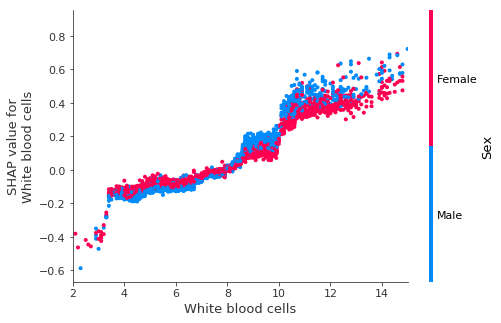

In [13]:
shap.dependence_plot("White blood cells", shap_values, X, display_features=X_display, show=False)
pl.xlim(2,15)
pl.show()

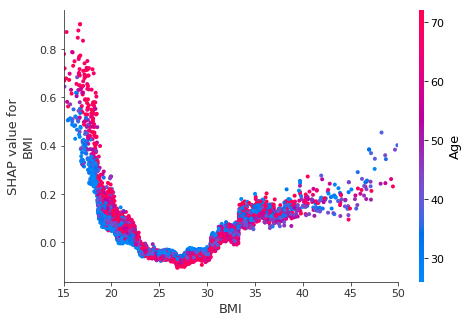

In [14]:
shap.dependence_plot("BMI", shap_values, X, display_features=X_display, show=False)
pl.xlim(15,50)
pl.show()

Could not find feature named: Serum magnesium


ValueError: m has more than 2 dimensions

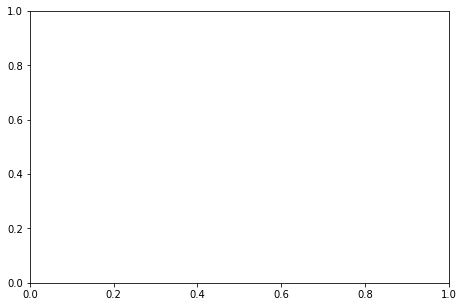

In [15]:
shap.dependence_plot("Serum magnesium", shap_values, X, show=False)
pl.xlim(1.2,2.2)
pl.show()

In [ ]:
shap.dependence_plot("Sedimentation rate", shap_values, X)

In [ ]:
shap.dependence_plot("Serum protein", shap_values, X)

In [ ]:
shap.dependence_plot("Serum cholesterol", shap_values, X, show=False)
pl.xlim(100,400)
pl.show()

In [ ]:
shap.dependence_plot("Pulse pressure", shap_values, X)

In [ ]:
shap.dependence_plot("Serum iron", shap_values, X, display_features=X_display)

In [ ]:
shap.dependence_plot("TS", shap_values, X)

In [ ]:
shap.dependence_plot("Red blood cells", shap_values, X)

## Compute SHAP Interaction Values

See the Tree SHAP paper for more details, but briefly, SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented in the latest version of XGBoost with the pred_interactions flag. With this flag XGBoost returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [ ]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])

### SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

In [ ]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

In [ ]:
shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

Now we plot the interaction effects involving age. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

In [ ]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
shap.dependence_plot(
    ("Age", "Systolic BP"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
shap.dependence_plot(
    ("Age", "White blood cells"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
shap.dependence_plot(
    ("Age", "Poverty index"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
shap.dependence_plot(
    ("Age", "BMI"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
shap.dependence_plot(
    ("Age", "Serum magnesium"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

Now we show a couple examples with systolic blood pressure.

In [ ]:
shap.dependence_plot(
    ("Systolic BP", "Systolic BP"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [ ]:
import matplotlib.pylab as pl
import numpy as np

In [ ]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()